In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import k_means
from helpers import *
%load_ext autoreload
%autoreload 2

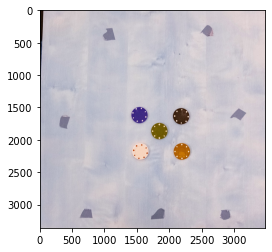

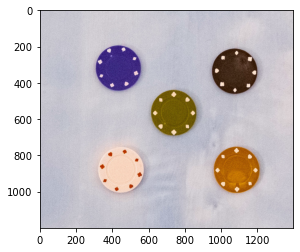

In [7]:
table_segmentation = segment_table("data/image_setup/chips.jpg")
plt.imshow(table_segmentation)
plt.show()

def get_brightness(img):
    gray_img = rgb2gray(img)
    norm = np.mean(gray_img)
    return norm

brightness = get_brightness(table_segmentation)

chips = table_segmentation[1300:2500,1100:2500]
plt.imshow(chips)
plt.show()

In [38]:
import cv2 as cv
from skimage.color import rgb2gray

def find_chips(chips, r_min=120, r_max=130):
    all_chips = chips.copy() 
    gray = cv.cvtColor(all_chips, cv.COLOR_BGR2GRAY)
    gray = cv.medianBlur(gray, 5)
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, r_min, param1=85, param2=15, minRadius=r_min, maxRadius=r_max)
    masks = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            one_chip = chips.copy()
            center = (i[0], i[1])
            radius = i[2]
            # print(radius)
            cv.circle(all_chips, center, radius, (0, 0, 0), thickness=-1)
            cv.circle(one_chip, center, radius, (0, 0, 0), thickness=-1)
            gray_chip = rgb2gray(one_chip)
            mask = (gray_chip < 0.0001).astype(int)
            masks.append(mask)
    gray2 = rgb2gray(all_chips)
    big_mask = (gray2 < 0.0001)
    return big_mask, masks

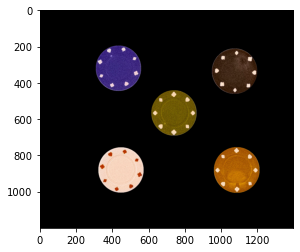

In [9]:
big_mask, masks = find_chips(chips)

chips2 = chips.copy()
chips2[big_mask==0] = 0

plt.imshow(chips2, cmap='gray')
plt.show()

In [10]:
from sklearn import cluster
from sklearn.mixture import GaussianMixture

g = cluster.KMeans(n_clusters=5).fit(chips[(big_mask == 1)]) 

[[ 64.46499657  43.8632035  130.67501716]
 [244.57487873 212.44794486 192.62108757]
 [176.94556167  99.00787627   7.72097543]
 [ 63.92352144  38.34573363  20.70316027]
 [111.91822975  88.09754458   6.90392573]]


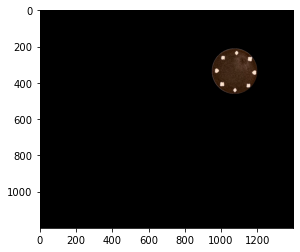

3


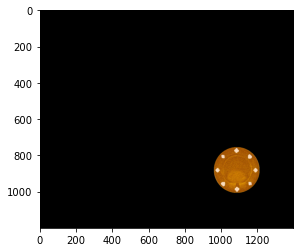

2


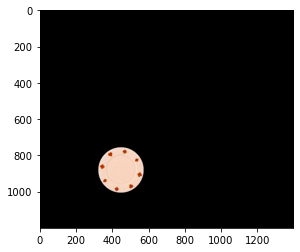

1


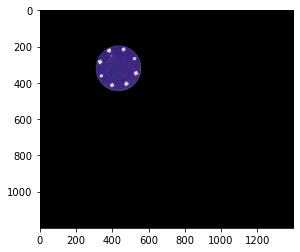

0


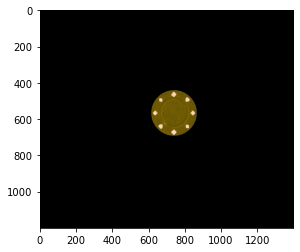

4


In [11]:
print(g.cluster_centers_)

for msk in masks:
    pred = g.predict(chips[msk == 1])
    chips3 = chips.copy()
    chips3[msk == 0] = 0
    plt.imshow(chips3)
    plt.show()
    labels = np.array([(pred==0).sum(), (pred==1).sum(), (pred==2).sum(), (pred==3).sum(), (pred==4).sum()])
    print(np.argmax(labels))

The centroids can be reused as we have:
- (244.61644278, 212.42504676, 192.49292637) for the white chips
- (63.91486714, 38.27724643, 20.43698002) for the black chips
- (112.0877551, 88.01122449, 6.35982143) for the green chips
- (63.13350215, 42.42452934, 130.4313773) for the blue chips
- (177.26876336, 99.27761832, 8.00378626) for the red chips

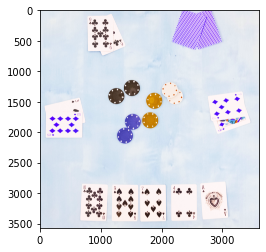

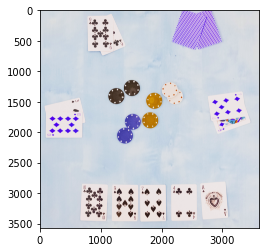

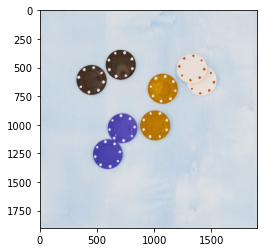

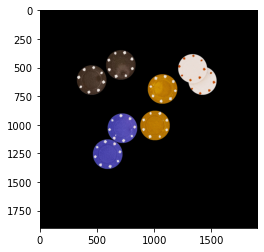

[0. 3. 2. 0. 3. 2. 1. 1.]
Number of red chips: 2
Number of green chips: 0
Number of white chips: 2
Number of blue chips: 2
Number of black chips: 2


In [53]:
table_segmentation = segment_table("data/train/train_27.jpg")
plt.imshow(table_segmentation)
plt.show()

from PIL import Image,ImageEnhance
img= Image.fromarray(table_segmentation)
img_brightness_obj=ImageEnhance.Brightness(img)
factor= brightness/get_brightness(table_segmentation) # (1 + brightness/get_brightness(table_segmentation))/2
enhanced_img=img_brightness_obj.enhance(factor)
plt.imshow(enhanced_img)
plt.show()

chips = np.array(enhanced_img)[800:2700,800:2700]

plt.imshow(chips)
plt.show()

big_mask, masks = find_chips(chips, r_min=120, r_max=130)

chips2 = chips.copy()
chips2[big_mask==0] = 0

plt.imshow(chips2, cmap='gray')
plt.show()

labels = np.array([])

for msk in masks:
    pred = g.predict(chips[msk == 1])
    labels = np.append(labels, np.argmax(np.array([(pred==0).sum(), (pred==1).sum(), (pred==2).sum(), (pred==3).sum(), (pred==4).sum()])))
    # chips3 = chips.copy()
    # chips3[msk == 0] = 0
    # plt.imshow(chips3)
    # plt.show()

print(labels)
print('Number of red chips:', (labels==2).sum())
print('Number of green chips:', (labels==4).sum())
print('Number of white chips:', (labels==1).sum())
print('Number of blue chips:', (labels==0).sum())
print('Number of black chips:', (labels==3).sum())